## Importing Essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model

# Algorithmns models to be compared
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Loading Training Dataset

In [2]:
df = pd.read_csv("german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Inspecting Data

In [3]:
df.shape

(1000, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


## Statistical Summary

In [5]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [6]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

## Exploratory Data Analysis

In [7]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

for col in cat_cols:
    print(df[col].value_counts(), "\n\n")

male      690
female    310
Name: Sex, dtype: int64 


own     713
rent    179
free    108
Name: Housing, dtype: int64 


little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64 


little      274
moderate    269
rich         63
Name: Checking account, dtype: int64 


car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
vacation/others         12
domestic appliances     12
Name: Purpose, dtype: int64 


good    700
bad     300
Name: Risk, dtype: int64 




In [8]:
# it's a library that we work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True)                  # this code, allow us to work with offline plotly version
import plotly.graph_objs as go                         # it's like "plt" of matplot
import plotly.tools as tls                             # It's useful to we get some tools of plotly
from collections import Counter                        # To do counter of some features
import plotly.figure_factory as ff

In [9]:
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit')

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit')


data = [trace0, trace1]
layout = go.Layout(
    yaxis=dict(
        title='Count'
         ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
py.iplot(fig, filename='grouped-bar')

<AxesSubplot:ylabel='Purpose'>

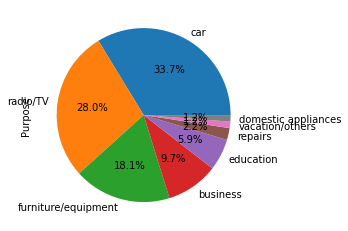

In [10]:
df['Purpose'].value_counts().plot(kind='pie', autopct='%1.1f%%')

<AxesSubplot:ylabel='Sex'>

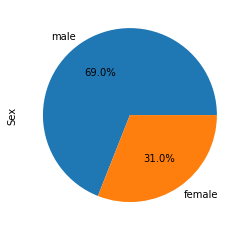

In [11]:
df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')

Number of Numerical Variable:  4


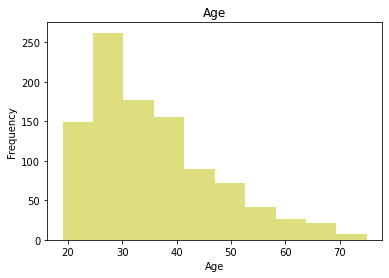

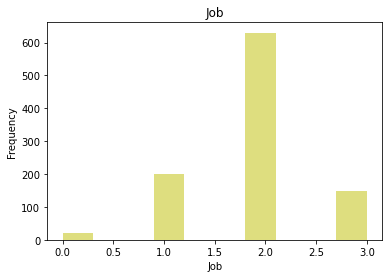

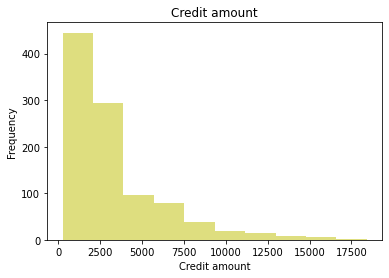

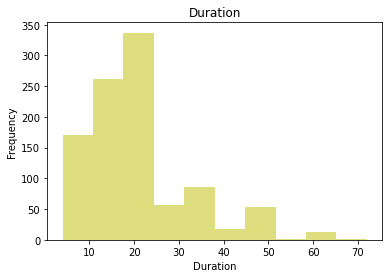

4 variables have been plotted


In [12]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Id"]
print('Number of Numerical Variable: ', len(num_cols))


def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].plot.hist(alpha=0.5, color='y')
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")


hist_for_nums(df, num_cols)

In [13]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

C:\Users\kislaykrishna\Anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [14]:
df['Housing'].value_counts()

own     713
rent    179
free    108
Name: Housing, dtype: int64

<AxesSubplot:ylabel='Housing'>

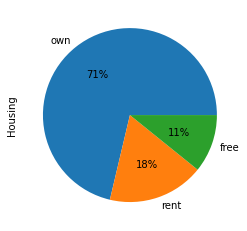

In [15]:
df['Housing'].value_counts().plot(kind='pie',autopct = "%1.0f%%")

In [16]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
     title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Housing-Grouped')

In [17]:
# Gender vs Purpose let's see the purpose of having credit loans for each gender.
df["Purpose"].unique()
sex_purpose = pd.crosstab(df['Purpose'], df['Sex']).apply(lambda x: x/x.sum() * 100)
sex_purpose

Sex,female,male
Purpose,,
business,6.129032,11.304348
car,30.322581,35.217391
domestic appliances,1.935484,0.869565
education,7.741935,5.072464
furniture/equipment,23.870968,15.507246
radio/TV,27.419355,28.260870
repairs,1.612903,2.463768
vacation/others,0.967742,1.304348


In [18]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Job"].value_counts().values,
    name='Good credit Distribuition'
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition"
)
data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
py.iplot(fig, filename='grouped-bar')

## Looking the diference by Sex

In [19]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Sex"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Sex"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Sex"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Sex"].value_counts().values,
    name="Bad Credit"
)
#Second plot
trace2 = go.Box(
    x = df[df["Risk"]== 'good']["Sex"],
    y = df[df["Risk"]== 'good']["Credit amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df[df["Risk"]== 'bad']["Sex"],
    y = df[df["Risk"]== 'bad']["Credit amount"],
    name=trace1.name
)
data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

C:\Users\kislaykrishna\Anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Checking Account variable

In [20]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Checking account"].value_counts().values,
    name='Good credit Distribuition' 
    
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Checking account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]
data = [trace0, trace1]

layout = go.Layout(
    title='Checking accounts Distribuition',
    xaxis=dict(title='Checking accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'Age-ba', validate = False)

<AxesSubplot:>

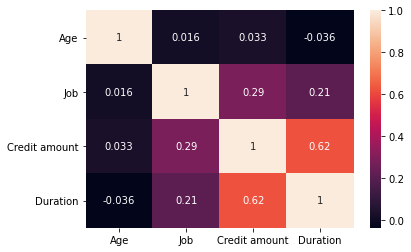

In [21]:
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:>

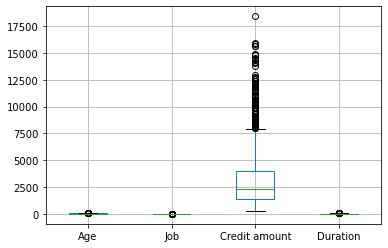

In [22]:
df.boxplot()

C:\Users\kislaykrishna\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Age'>

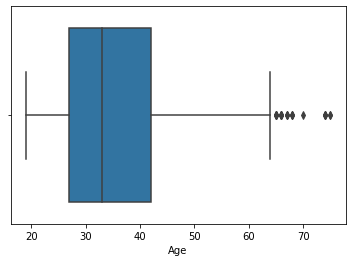

In [23]:
sns.boxplot(df['Age'])

C:\Users\kislaykrishna\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Credit amount'>

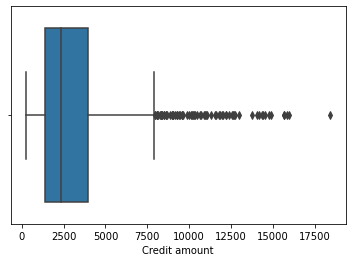

In [24]:
sns.boxplot(df['Credit amount'])

## Dealing with outliers

In [25]:
Q1 = df["Age"].quantile(0.25)

Q3 = df["Age"].quantile(0.75)

IQR = Q3 - Q1

print(IQR)

15.0


In [26]:
Lower_Fence = Q1 - (1.5 * IQR)

Upper_Fence = Q3 + (1.5 * IQR)

print(Lower_Fence)

print(Upper_Fence)

4.5
64.5


In [27]:
df[((df["Age"] < Lower_Fence) |(df["Age"] > Upper_Fence))]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
75,66,male,3,free,little,little,1526,12,car,good
137,66,male,1,own,quite rich,moderate,766,12,radio/TV,bad
163,70,male,3,free,little,moderate,7308,10,car,good
179,65,male,2,own,little,little,571,21,car,good
186,74,female,3,free,little,moderate,5129,9,car,bad
187,68,male,0,free,little,moderate,1175,16,car,good
213,66,male,3,own,little,rich,1908,30,business,bad
330,75,male,3,free,little,little,6615,24,car,good
430,74,male,1,own,little,NaN,3448,5,business,good


In [28]:
df['Age'] = np.where(df['Age']>Upper_Fence,Upper_Fence,df['Age'])

C:\Users\kislaykrishna\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Age'>

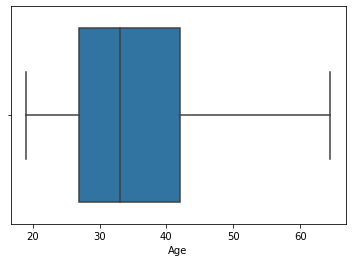

In [29]:
sns.boxplot(df['Age'])

## Looking the total of values in each categorical feature

In [30]:
print("Purpose : ",df.Purpose.unique())
print(" ")
print("Sex : ",df.Sex.unique())
print(" ")
print("Housing : ",df.Housing.unique())
print(" ")
print("Saving accounts : ",df['Saving accounts'].unique())
print(" ")
print("Risk : ",df['Risk'].unique())
print(" ")
print("Checking account : ",df['Checking account'].unique())
print(" ")
print("Age_cat : ",df['Age'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
 
Sex :  ['male' 'female']
 
Housing :  ['own' 'free' 'rent']
 
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
 
Risk :  ['good' 'bad']
 
Checking account :  ['little' 'moderate' nan 'rich']
 
Age_cat :  [64.5 22.  49.  45.  53.  35.  61.  28.  25.  24.  60.  32.  44.  31.
 48.  26.  36.  39.  42.  34.  63.  27.  30.  57.  33.  37.  58.  23.
 29.  52.  50.  46.  51.  41.  40.  47.  56.  54.  20.  21.  38.  43.
 55.  64.  19.  62.  59. ]


## Dealing with missing value

In [31]:
df['Saving accounts'] = df['Saving accounts'].fillna(value=df['Saving accounts'].mode())
df['Checking account'] = df['Checking account'].fillna(value=df['Checking account'].mode())

## Dealing with skewed data

In [32]:
df['Credit amount'] = np.log(df['Credit amount'])

In [33]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

# And let's re-create "df_bad" dataframes with "df_good" we created.
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

In [34]:
df.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,64.5,male,2,own,little,little,7.063904,6,radio/TV,good,Senior
1,22.0,female,2,own,little,moderate,8.691315,48,radio/TV,bad,Student
2,49.0,male,1,own,little,NaN,7.647786,12,education,good,Adult


In [35]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [36]:
# # Creating a target column
df['target'] = df['Risk'].apply(lambda x: 1 if x == 'bad' else 0)
df.drop('Risk', axis=1, inplace=True)
df.head(4)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Age_cat,target
0,64.5,male,2,own,little,little,7.063904,6,radio/TV,Senior,0
1,22.0,female,2,own,little,moderate,8.691315,48,radio/TV,Student,1
2,49.0,male,1,own,little,NaN,7.647786,12,education,Adult,0
3,45.0,male,2,free,little,little,8.972337,42,furniture/equipment,Adult,0


In [37]:
#Creating the X and y variables
X = df.drop('target', 1)
y = df["target"]

In [38]:
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [39]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (750, 10)
Shape of X_test: (250, 10)


In [40]:
tnf = ColumnTransformer(
    [
        ('nominal',OneHotEncoder(drop='first',sparse=False),['Sex','Housing','Saving accounts','Checking account',"Purpose","Age_cat"])
    ], remainder='passthrough'
)

In [41]:
X_train_tnf = tnf.fit_transform(X_train)
X_test_tnf = tnf.transform(X_test)

### RandomForest Classifier

In [42]:
rf = RandomForestClassifier(random_state=42)

# Train Model 
rf.fit(X_train_tnf, y_train)

# Prediction on Test set
pred_rf = rf.predict(X_test_tnf)

# Accuracy on test set: 
print("Test Accuracy: ", accuracy_score(pred_rf, y_test))

Test Accuracy:  0.712


In [43]:
rf1 = RandomForestClassifier(n_estimators=250, max_features=10, max_depth=7, random_state=2)

# Train data
rf1.fit(X_train_tnf, y_train)

# prediction on Test set
pred_rf1 = rf1.predict(X_test_tnf)

# Accuracy on test set
print("Test Accuracy: ", accuracy_score(pred_rf1, y_test))

Test Accuracy:  0.74


### Hyper Parameters tuning

In [44]:
#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=2, scoring='recall', verbose=1)
grid_search.fit(X_train_tnf, y_train)

Fitting 2 folds for each of 120 candidates, totalling 240 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [4, 7, 15, 20],
                         'n_estimators': [3, 5, 10, 25, 50, 150]},
             scoring='recall', verbose=1)

In [45]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.42543859649122806
{'max_depth': 10, 'max_features': 15, 'n_estimators': 3}


In [46]:
rf = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=3, random_state=2)

#trainning with the best params
rf.fit(X_train_tnf, y_train)


RandomForestClassifier(max_features=20, n_estimators=3, random_state=2)

In [47]:
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(X_test_tnf)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=2))


0.7


[[146  32]
 [ 43  29]]


0.4154727793696275


### Support vector Machine

In [48]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Implement gridsearchcv to see which are our best parameter

params = {'C': [0.75, 0.85, 0.95, 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [3, 4, 5]}

svc_clf = SVC(random_state=42)

grid_search_cv = GridSearchCV(svc_clf, params)
grid_search_cv.fit(X_train_tnf, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.75, 0.85, 0.95, 1], 'degree': [3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [49]:
grid_search_cv.best_estimator_

SVC(C=0.95, kernel='linear', random_state=42)

In [50]:
grid_search_cv.best_params_

{'C': 0.95, 'degree': 3, 'kernel': 'linear'}

In [51]:
svc_clf = grid_search_cv.best_estimator_
svc_clf.fit(X_train_tnf, y_train)

SVC(C=0.95, kernel='linear', random_state=42)

In [52]:
svc_clf.score(X_train_tnf, y_train)

0.7613333333333333

In [53]:
from sklearn.metrics import accuracy_score

svc_clf.fit(X_train_tnf, y_train)
y_pred = svc_clf.predict(X_test_tnf)

# Accuracy score 71%
accuracy_score(y_test, y_pred)

0.752

### GradientBoosting Classifier

In [54]:
gb = GradientBoostingClassifier()

# Training model
gb.fit(X_train_tnf, y_train)

# Prediction on test set
gb_pred = gb.predict(X_test_tnf)

# Accuracy score on Test set
print("Test Accuracy: ", accuracy_score(y_test, gb_pred))

Test Accuracy:  0.74


### HyperParameter Tuning

In [55]:
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [56]:
from sklearn.model_selection import RandomizedSearchCV
cv = RandomizedSearchCV(gb,parameters,cv=2)
cv.fit(X_train_tnf,y_train)

RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [5, 50, 250, 500]})

In [57]:
gb =cv.best_estimator_
gb.fit(X_train_tnf, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=250)

In [58]:
gb.score(X_train_tnf, y_train)

0.792

In [59]:
gb.fit(X_train_tnf, y_train)
y_pred2 = gb.predict(X_test_tnf)

# Accuracy score 71%
accuracy_score(y_test, y_pred2)

0.744

In [60]:
from sklearn.model_selection import cross_val_score

In [61]:
import pickle

In [62]:
pickle.dump(svc_clf,open('model.pkl','wb'))